# Russia-Ukraine War Sentiment Analysis on Tweets
On 23rd February, Russia announced special military operation on Ukraine. This geopolitical incident has been put under the limelight. As people gather on social media to express their opinion on the incident, it will be insightful to analyse their sentiment in an attempt to understand the public opinion.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import yaml
import tweepy
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Collecting tweets
We use Tweepy which is built on Twitter API to collect tweets. Basic data cleaning is done on data, such as removing URL to minimise its effect on extracting the sentiment of user. 

In [ ]:
with open('config.yaml') as file:
    keys = yaml.safe_load(file)
    consumer_key = keys['search_tweets_api']['consumer_key']
    consumer_secret = keys['search_tweets_api']['consumer_secret']
    access_token = keys['search_tweets_api']['access_token']
    access_token_secret = keys['search_tweets_api']['access_token_secret']

In [ ]:
def auth():
    try:
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        api = tweepy.API(auth, wait_on_rate_limit=True)
    except:
        print('An error occurred during the authentication')
    return api

In [ ]:
# function to remove URL
def remove_url(txt):
    return ' '.join(re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', txt).split())

# function to remove time
def remove_time(datetime):
    return str(datetime).split(' ')[0]

In [ ]:
def search_by_hashtag(api, date_until, words, max):
    df = pd.DataFrame(columns=['id', 'created_at', 'username', 'location', 'following', 
                               'followers', 'retweetcount', 'text']) 
    tweets = tweepy.Cursor(api.search_tweets, q=words, lang='en', until=date_until, tweet_mode='extended').items(max) 
    list_tweets = [tweet for tweet in tweets] 
    
    for tweet in list_tweets: 
        id = tweet.id
        created_at = remove_time(tweet.created_at)
        username = tweet.user.screen_name 
        location = tweet.user.location 
        following = tweet.user.friends_count 
        followers = tweet.user.followers_count  
        retweetcount = tweet.retweet_count 
    
        try: 
            text = tweet.retweeted_status.full_text 
        except AttributeError: 
            text = tweet.full_text 
        text = remove_url(text)

        tweets = [id, created_at, username, location, following, followers, retweetcount, text]

        df.loc[len(df)] = tweets # add current tweet to the last
          
    return df

In [ ]:
api = auth()
words = 'Ukraine Russia -filter:retweets'
date_until = '2022-02-25'
df = search_by_hashtag(api, date_until, words, 100000)

In [3]:
df.head()

Unnamed: 0                   id                 created_at  \
0           0  1496635945155960835  2022-02-23 23:59:50+00:00   
1           1  1496635862574321669  2022-02-23 23:59:30+00:00   
2           2  1496635580532211712  2022-02-23 23:58:23+00:00   
3           3  1496635414517481472  2022-02-23 23:57:43+00:00   
4           4  1496635050888208388  2022-02-23 23:56:16+00:00   

          username           location  following  followers  retweetcount  \
0      DafinStudio                NaN        200         67             1   
1  martinigrimaldi                NaN         97      10525             0   
2          anainkc    Kansas City, MO         66        490             7   
3         keddle01                NaN       5026       5112          1020   
4        Macid3000  51.46386,0.006213       4825       2211          8886   

                                                text  
0  I Stand With Ukraine TShirtUkraineRussiaCrisis...  
1  Titles that will make history Japan imposes sa...  
2  AND JUST LIKE THAT INFLATION THE supplychaincr...  
3  The Simpsons predicted theCrisis of Putin Russ...  
4  Putin convened an unscheduled meeting with his...

## Sentiment Analysis
### Microsoft Azure
We adopt Text Analytics in Azure Cognitive Services to obtain the sentiment score of tweets. The API can ouput confidence scores of the text being postive, neutral and negative respectively. For consistency and easier understanding, we will map the scores into a composite score in range [-1. 1].

In [8]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    with open('config.yaml') as file:
        keys = yaml.safe_load(file)
        key = keys['azure']['subscription_key']
        endpoint = keys['azure']['endpoint']
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

In [9]:
# Function for detecting sentiment in text
def sentiment_analysis_example(client):

    documents = list(df['text'])
    polarity = []
    azure_class = []
    # For loop is used to bypass the batch request limit
    for document in documents:
        response = client.analyze_sentiment(documents=[document])[0]
        azure_class.append(response.sentiment)
        polarity.append(0 + response.confidence_scores.positive - response.confidence_scores.negative)
    df['azure_polar'] = polarity
    df['azure_class'] = azure_class

client = authenticate_client()      
sentiment_analysis_example(client)

### TextBlob
Textblob is an open-source python library for processing textual data. It can evaluate both polarity and subjectivity in text. The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [10]:
sentiment_objects = [TextBlob(tweet) for tweet in list(df['text'])]
blob_polar = [tweet.sentiment.polarity for tweet in sentiment_objects]
blob_subj = [tweet.sentiment.subjectivity for tweet in sentiment_objects]
df['blob_polar'] = blob_polar
df['blob_subj'] = blob_subj

### Results

In [11]:
df.to_csv('processed_tweets.csv')
df.head(3)

Unnamed: 0                   id                 created_at  \
0           0  1496635945155960835  2022-02-23 23:59:50+00:00   
1           1  1496635862574321669  2022-02-23 23:59:30+00:00   
2           2  1496635580532211712  2022-02-23 23:58:23+00:00   

          username         location  following  followers  retweetcount  \
0      DafinStudio              NaN        200         67             1   
1  martinigrimaldi              NaN         97      10525             0   
2          anainkc  Kansas City, MO         66        490             7   

                                                text  azure_polar azure_class  \
0  I Stand With Ukraine TShirtUkraineRussiaCrisis...        -0.96    negative   
1  Titles that will make history Japan imposes sa...        -0.05     neutral   
2  AND JUST LIKE THAT INFLATION THE supplychaincr...         0.01     neutral   

   blob_polar  blob_subj  
0         0.0        0.0  
1         0.0        0.1  
2         0.0        0.0

## Further Analysis

In [4]:
df = pd.read_csv('processed_tweets.csv')

We first compare the sentiment scores rated by TextBlob and Azure respectively. It can be seen from the figure that Azure has a wider spectrum of sentiment, suggesting that it uses a more advanced algorithm to analyse the sentiment in text.

Text(0.5, 1.0, 'Sentiments analysed by Azure')

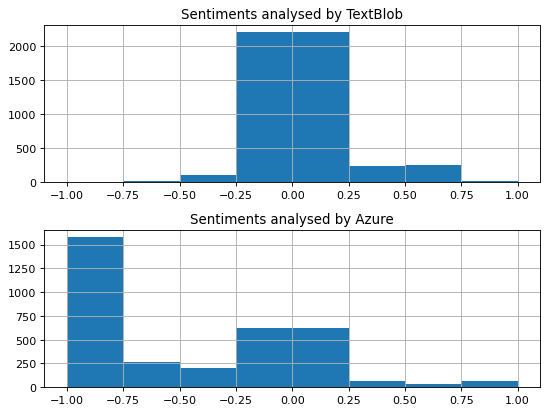

In [14]:
plt.figure(figsize=(8, 6), dpi=80)

ax1 = plt.subplot(2, 1, 1)
df.hist(column='blob_polar', bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax1)
ax1.set_title('Sentiments analysed by TextBlob')

ax2 = plt.subplot(2, 1, 2)
df.hist(column='azure_polar', bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax2)
ax2.set_title('Sentiments analysed by Azure')

<AxesSubplot:title={'center':'Sentiment Class of Tweets on Ukraine-Russia War'}>

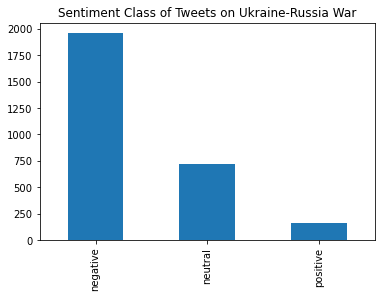

In [15]:

df['azure_class'].value_counts().plot(kind='bar', title='Sentiment Class of Tweets on Ukraine-Russia War')

Regarding the sentiment of tweets, we can see a general trend towards negative sentiment, which is in line with the common belief that people do not like war. To understand the general opinion better, we can look at key words presented in each sentiment class.

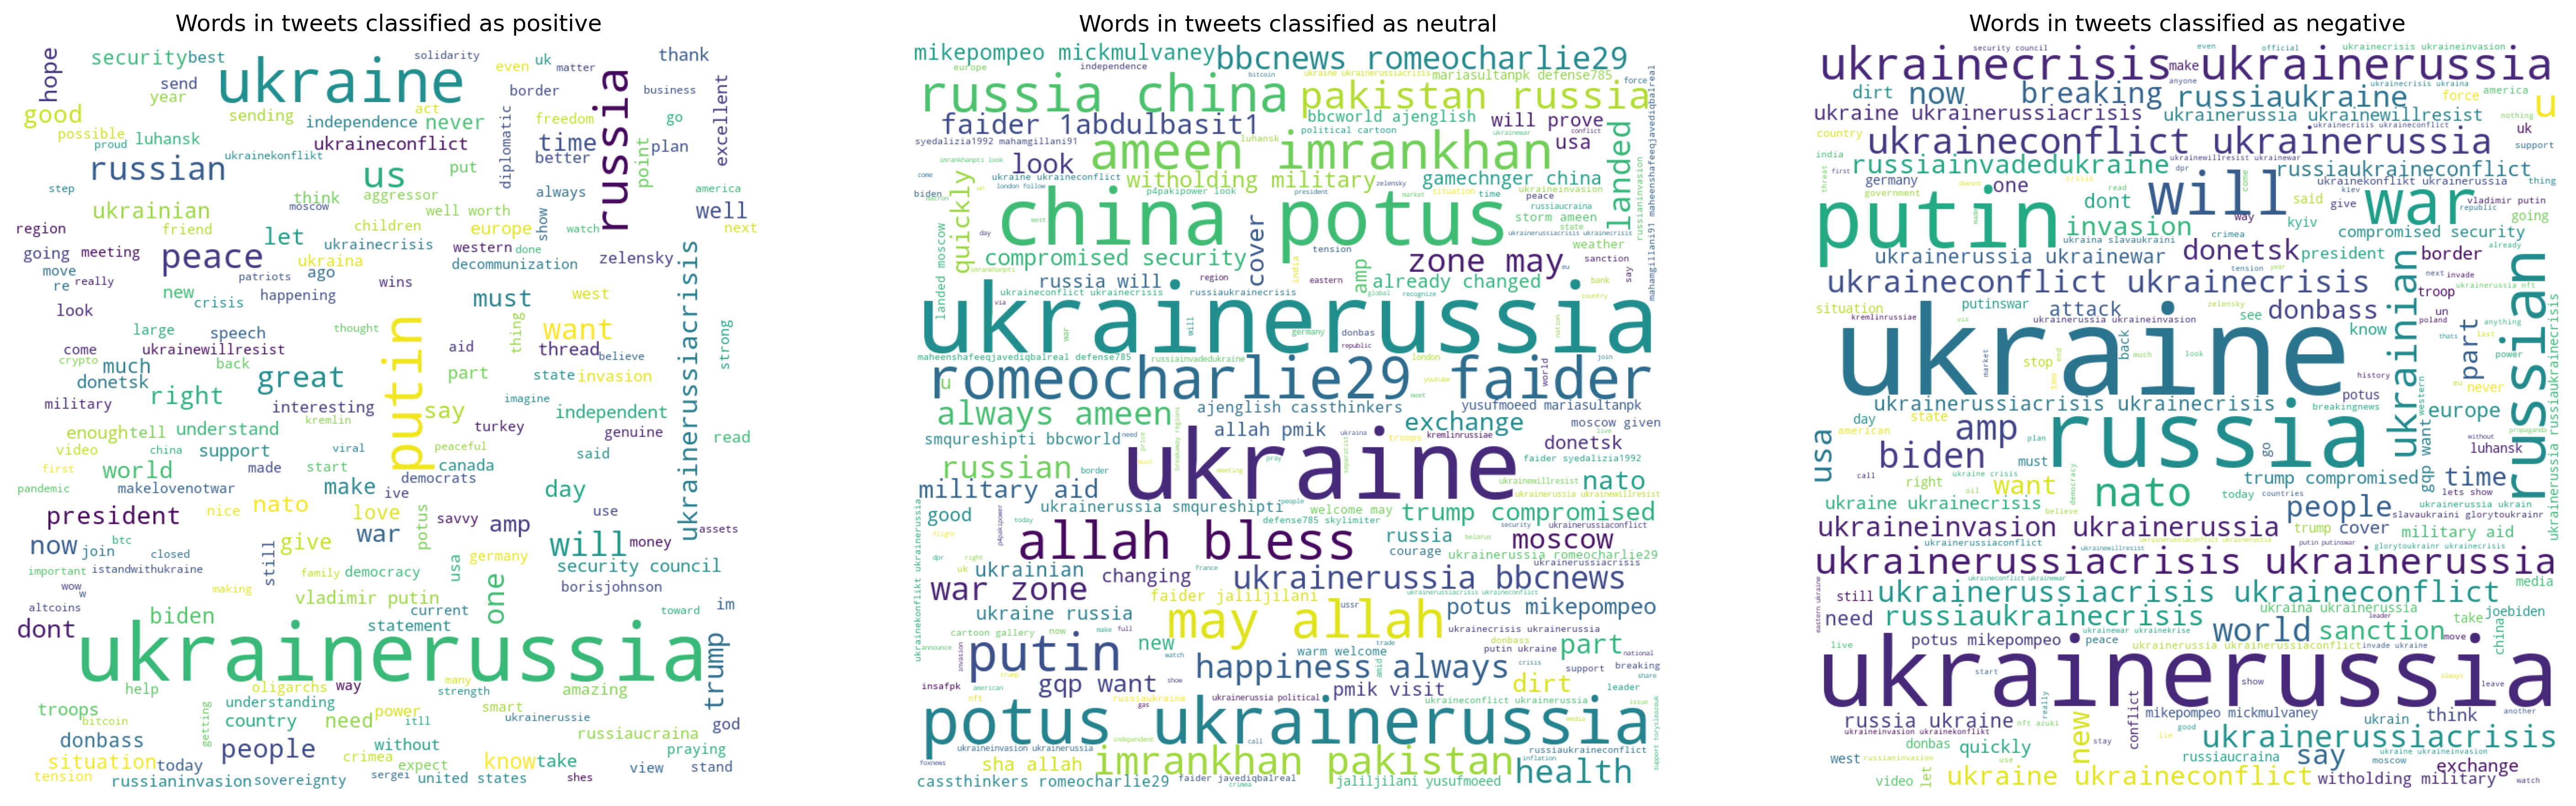

In [31]:
fig = plt.figure(figsize=(24, 72), dpi=300)
for index, sentiment in enumerate(['positive', 'neutral', 'negative']):
    words = []
    tokens = [str(sentence).split() for sentence in list(df[df['azure_class'] == sentiment]['text'])]
    for i in range(len(tokens)):
        for word in tokens[i]:
            word = word.lower()
            words.append(word)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(' '.join(words))
    ax = plt.subplot(1, 3, index+1)
    ax.imshow(wordcloud)
    ax.set_title(f'Words in tweets classified as {sentiment}')
    ax.axis("off")

Some remarkable keywords in respective classes include:
- Positive: peace, support, independent
- Neutral: mostly proper nouns
- Negative: crisis, war, invasion

Aside from the aggregate analysis, we can also look at the change in sentiment of users.

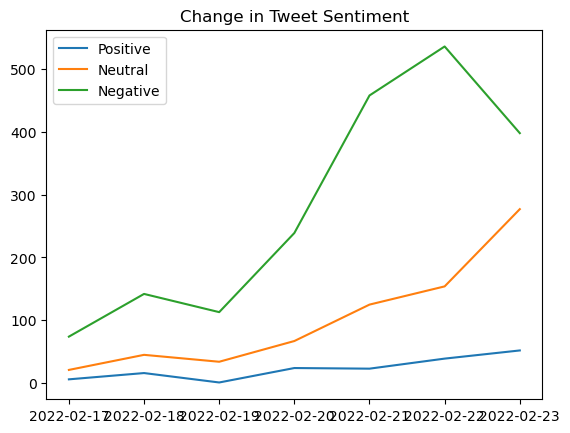

In [9]:
positive_count = []
neutral_count = []
negative_count = []
days = np.unique(list(map(lambda x: x.split(' ')[0], df['created_at'])))
for day in days:
    current = df[df['created_at'].str.contains(day)]
    positive_count.append(current[current['azure_class'] == 'positive']['id'].count())
    neutral_count.append(current[current['azure_class'] == 'neutral']['id'].count())
    negative_count.append(current[current['azure_class'] == 'negative']['id'].count())
count = pd.DataFrame({'Positive': positive_count, 'Neutral': neutral_count, 'Negative': negative_count}, index=days)
count.plot(title='Change in Tweet Sentiment')
plt.show()

At last, we examine the subjectivity of tweets.

Text(0.5, 1.0, 'Subjectivity from Tweets on Ukraine-Russia War')

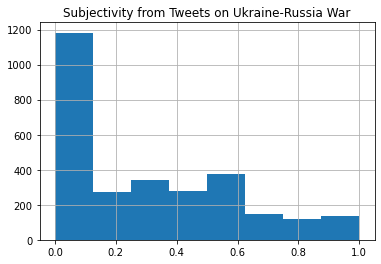

In [30]:
fig, ax = plt.subplots()
df.hist(column='blob_subj', bins=[0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], ax=ax)
ax.set_title('Subjectivity from Tweets on Ukraine-Russia War')

It can be seen that most users are objective, which is unusual on social media. This can be attributed to the fact that people tend to express objective opinion while sharing news.